In [1741]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

In [1742]:
# Import future ENT appointments
data = pd.read_csv("../future_appts_trans_ENT.csv")
data

,appointment_id,age_deid,bmi_deid,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,substance_misuse,...,appt_date,ethnicity_trans,tfc_name_trans,patient_on_multiple_pathways_trans,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,17479744,57,27.45,1,0,1,1,0,0,0,...,2024-06-26,3,7,0,6,0,10,1,0,3
1,17631073,17,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,1,0,3
2,17659262,27,21.70,0,0,0,4,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,2
3,17659348,57,21.70,0,0,0,3,0,0,0,...,2024-05-07,5,7,0,5,0,10,2,0,3
4,17659361,27,27.45,0,1,0,2,0,0,0,...,2024-05-07,3,7,0,5,0,10,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,20183628,47,27.45,0,0,1,2,0,0,0,...,2024-06-19,5,7,0,6,0,10,1,0,1
2556,20183649,57,40.00,0,1,0,1,0,0,0,...,2024-06-08,3,7,0,5,0,10,2,0,3
2557,20183782,32,21.70,0,0,0,4,0,0,0,...,2024-05-25,3,7,0,7,0,10,6,0,1
2558,20183795,62,39.45,0,0,0,1,0,0,0,...,2024-06-17,3,7,0,6,0,10,3,0,1


In [1743]:
# Filter for surgeons & new appointments only
surgeon_new = data[data["reason_display"].isin(["Adult ENT New", "Adult ENT Thyroid New"])]

In [1744]:
# Within the surgeons & new appointments only, filter for very high risk appointments
surgeon_new_very_high = surgeon_new[surgeon_new["did_not_attend_risk_group_trans"] == 4]

In [1745]:
# Count number of unique appointment durations
surgeon_new["appt_duration"].value_counts()

appt_duration
15.0    1958
30.0     198
20.0      33
10.0      16
75.0       3
Name: count, dtype: int64

In [1746]:
# Split out the appointment durations
surgeon_new_10 = surgeon_new[surgeon_new["appt_duration"] == 10]
surgeon_new_15 = surgeon_new[surgeon_new["appt_duration"] == 15]
surgeon_new_20 = surgeon_new[surgeon_new["appt_duration"] == 20]
surgeon_new_30 = surgeon_new[surgeon_new["appt_duration"] == 30]
surgeon_new_75 = surgeon_new[surgeon_new["appt_duration"] == 75]

# Split out the very high risk appointments
surgeon_new_very_high_10 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 10]
surgeon_new_very_high_15 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 15]
surgeon_new_very_high_20 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 20]
surgeon_new_very_high_30 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 30]
surgeon_new_very_high_75 = surgeon_new_very_high[surgeon_new_very_high["appt_duration"] == 75]

In [1747]:
# Group weekswaiting as per NHS guidelines
data["weekswaiting"]
data["weekswaiting_grouped"] = pd.cut(data["weekswaiting"], bins=[0, 17, 51, 76, float("inf")], labels=["0-17", "18-51", "52-77", ">78"])
data[["weekswaiting","weekswaiting_grouped"]]

,weekswaiting,weekswaiting_grouped
0,53.0,52-77
1,82.0,>78
2,55.0,52-77
3,55.0,52-77
4,54.0,52-77
...,...,...
2555,44.0,18-51
2556,13.0,0-17
2557,49.0,18-51
2558,11.0,0-17


### V1: overbook any (other risk levels) into very high risk based on weeks waiting

In [1748]:
# # Sort the appointments by weekswaiting (descending; all except the very high risk ones)
# weekswaiting_desc = surgeon_new[surgeon_new["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
#     # ? Create a new df with >78 weeks waiting - prioritise these patients; but if < # of slots, then fill with 18-52 week patients?



# Sort the individual appointment durations by weekswaiting (descending; all except the very high risk ones)
weekswaiting_desc_10 = surgeon_new_10[surgeon_new_10["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_15 = surgeon_new_15[surgeon_new_15["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_20 = surgeon_new_20[surgeon_new_20["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_30 = surgeon_new_30[surgeon_new_30["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_75 = surgeon_new_75[surgeon_new_75["did_not_attend_risk_group_trans"] != 4].sort_values(by="weekswaiting", ascending=False)

In [1749]:
# Create queues for the "other risk level" appointments
queue10 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10[["appointment_id", "appt_date"]].values.tolist()])
queue15 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15[["appointment_id", "appt_date"]].values.tolist()])
queue20 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20[["appointment_id", "appt_date"]].values.tolist()])
queue30 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30[["appointment_id", "appt_date"]].values.tolist()])
queue75 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time = len(queue10)*10 + len(queue15)*15 + len(queue20)*20 + len(queue30)*30 + len(queue75)*75
print("Sum of starting queue time (V1):", queue_time)

Sum of starting queue time (V1): 32475


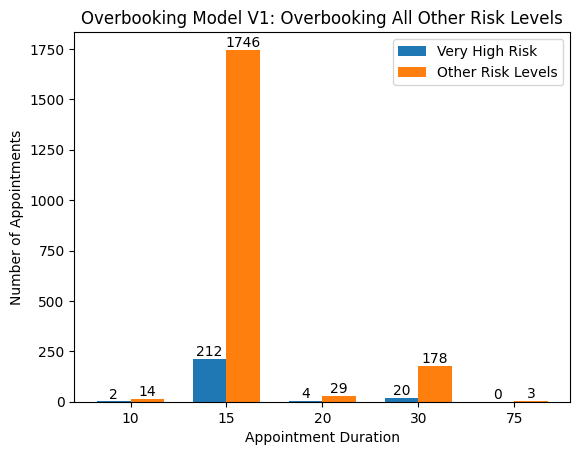

In [1750]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10),
    len(queue15),
    len(queue20),
    len(queue30),
    len(queue75),
]

# Define the durations
durations = [10, 15, 20, 30, 75]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Other Risk Levels")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model V1: Overbooking All Other Risk Levels")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [1751]:
# Function to overbook the very high risk appointments
def overbook_appointments(very_high_group, queue):
    overbooked_appointments = []
    for index, very_high_appt in very_high_group.iterrows():
        very_high_date = pd.to_datetime(very_high_appt["appt_date"])
        overbooked = False
        # Create a new, temporary queue to hold appointments that are not suitable for the current very_high_appt for later evaluation
        temp_queue = deque()
        
        while queue:
            # Pop the earliest appointment from the queue
            earliest_appointment_id, earliest_date = queue.popleft()
            # Check if the very_high_date is earlier than the earliest_date
            if very_high_date < earliest_date:
                # Overbook the very high risk slot with the remaining appointment
                overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
                overbooked = True
                break
            else:
                # If the date is not suitable, move the appointment to the temporary queue
                temp_queue.append((earliest_appointment_id, earliest_date))
        
        # Merge the temporary queue back into the original queue
        queue.extendleft(reversed(temp_queue))
        
        if not overbooked:
            # No more appointments to overbook
            overbooked_appointments.append((very_high_appt["appointment_id"], None))
    
    return overbooked_appointments

# Overbook each very high risk appointment duration group
overbooked_10 = overbook_appointments(surgeon_new_very_high_10, queue10)
overbooked_15 = overbook_appointments(surgeon_new_very_high_15, queue15)
overbooked_20 = overbook_appointments(surgeon_new_very_high_20, queue20)
overbooked_30 = overbook_appointments(surgeon_new_very_high_30, queue30)
overbooked_75 = overbook_appointments(surgeon_new_very_high_75, queue75)

# Combine all overbooked results
all_overbooked_appointments = overbooked_10 + overbooked_15 + overbooked_20 + overbooked_30 + overbooked_75

# Convert to DataFrame
overbooked_df = pd.DataFrame(all_overbooked_appointments, columns=["very_high_appt_id", "overbooked_appt_id"])
overbooked_df

,very_high_appt_id,overbooked_appt_id
0,19853208,19971567.0
1,20111728,NaN
2,17671208,17671294.0
3,17901062,17667391.0
4,18011196,20112378.0
...,...,...
233,19938829,20141614.0
234,19971221,19881525.0
235,19972250,20056268.0
236,20055757,20055807.0


In [1752]:
# Check if any duplicated overbooked appointments
overbooked_df.dropna(subset=["overbooked_appt_id"])[overbooked_df.dropna(subset=["overbooked_appt_id"]).duplicated("overbooked_appt_id", keep=False)]

,very_high_appt_id,overbooked_appt_id


In [1753]:
# Check the funtion works properly by evaluating 10-minute appointments
print(overbooked_10)
print(len(overbooked_10))
print(len(surgeon_new_very_high_10))
print(len(queue10))


[(19853208, 19971567), (20111728, None)]
2
2
13


In [1754]:
# Calculate time gap of the overbooked appointments (original vs new/overbooked)

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df = pd.merge(overbooked_df, 
                            data[["appointment_id", "appt_date", "did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                                          "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df = pd.merge(overbooked_df,
                            data[["appointment_id", "appt_date", "did_not_attend_risk", "weekswaiting","appt_duration"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk",
                                                                                                                          "weekswaiting": "original_overbooked_weekswaiting",}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])

# Calculate the time gap between the original and overbooked appointments
overbooked_df["time_gap_days"] = (pd.to_datetime(overbooked_df["original_overbooked_appt_date"]) - pd.to_datetime(overbooked_df["very_high_appt_date"])).dt.days

# Convert time_gap_days into weeks
overbooked_df["time_gap_weeks"] = overbooked_df["time_gap_days"] / 7

overbooked_df

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,time_gap_days,time_gap_weeks
0,19853208,19971567.0,2025-01-29,0.619074,2025-01-30,0.344912,7.0,10.0,1.0,0.142857
1,20111728,NaN,2025-04-02,0.656163,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,17671294.0,2024-05-20,0.710675,2024-05-23,0.318434,59.0,15.0,3.0,0.428571
3,17901062,17667391.0,2024-05-09,0.455411,2024-05-20,0.261759,60.0,15.0,11.0,1.571429
4,18011196,20112378.0,2024-05-23,0.775510,2025-03-07,0.275752,59.0,15.0,288.0,41.142857
...,...,...,...,...,...,...,...,...,...,...
233,19938829,20141614.0,2025-04-15,0.473121,2025-05-06,0.179040,11.0,30.0,21.0,3.000000
234,19971221,19881525.0,2025-04-15,0.489043,2025-04-24,0.291788,9.0,30.0,9.0,1.285714
235,19972250,20056268.0,2025-05-29,0.461040,2025-07-24,0.244307,8.0,30.0,56.0,8.000000
236,20055757,20055807.0,2025-07-03,0.793514,2025-07-17,0.408785,6.0,30.0,14.0,2.000000


Avg. time gap (V1): 34.59915611814346
Median time gap (V1): 17.0


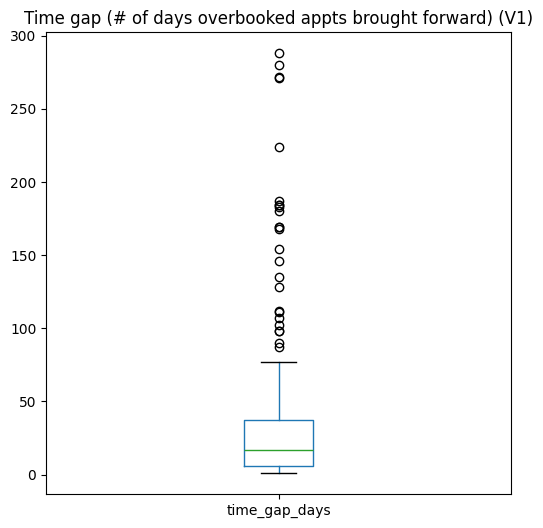

In [1755]:
# Calculate the average time gap
print("Avg. time gap (V1):", overbooked_df["time_gap_days"].mean())
print("Median time gap (V1):", overbooked_df["time_gap_days"].median())


# Plot boxplot
overbooked_df.boxplot(column="time_gap_days", figsize=(6, 6), grid=False)
plt.title("Time gap (# of days overbooked appts brought forward) (V1)")
plt.show()

In [1756]:
# Count the remaining appointments in each queue
remaining_10 = len(queue10) * 10
remaining_15 = len(queue15) * 15
remaining_20 = len(queue20) * 20
remaining_30 = len(queue30) * 30
remaining_75 = len(queue75) * 75

# Sum the remaining appointments
remainder_queue_time = remaining_10 + remaining_15 + remaining_20 + remaining_30 + remaining_75
remainder_queue_time

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (V1):", overbooked_df["appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (V1):", queue_time - remainder_queue_time)

Sum of overbooked duration (V1): 3870.0
Sum of queue utilised (V1): 3870


Mean joint probability (V1): 0.15468837227421017
Median joint probability (V1): 0.14394197680627172


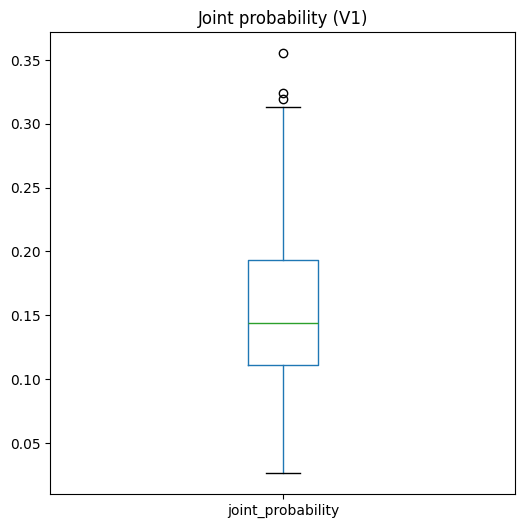

In [1757]:
# Calculate probability of clinic overtime
overbooked_df["joint_probability"] = overbooked_df["very_high_dna_risk"] * overbooked_df["original_overbooked_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (V1):", overbooked_df["joint_probability"].mean())
print("Median joint probability (V1):", overbooked_df["joint_probability"].median())

# Plot boxplot
overbooked_df.boxplot(column="joint_probability", figsize=(6, 6), grid=False)
plt.title("Joint probability (V1)")
plt.show()


Mean clinic overtime (per appointment scenario) (V1): 5.056564466031308
Median clinic overtime (per appointment scenario) (V1): 4.519610507729897
Spread of clinic overtime (Q3-Q1): 2.738828736169388


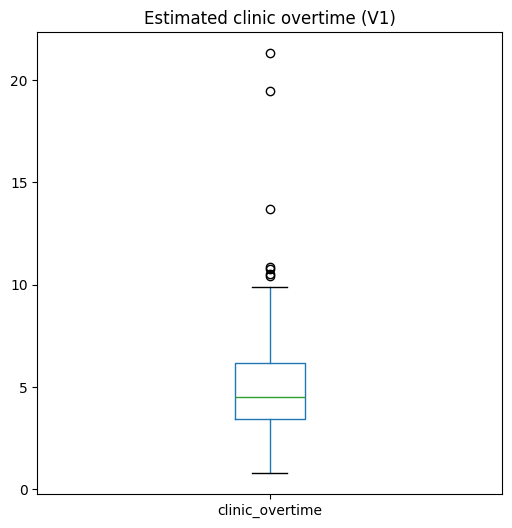

In [1758]:
# Calculate estimated clinic overtime
overbooked_df["clinic_overtime"] = overbooked_df["joint_probability"] * (overbooked_df["appt_duration"]*2)

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (V1):", overbooked_df["clinic_overtime"].mean())
print("Median clinic overtime (per appointment scenario) (V1):", overbooked_df["clinic_overtime"].median())

# Quantiles - what you want is the spread (Q3-Q1) to be as small as possible
print("Spread of clinic overtime (Q3-Q1):", overbooked_df["clinic_overtime"].quantile(0.75) - overbooked_df["clinic_overtime"].quantile(0.25))

# Plot boxplot
overbooked_df.boxplot(column="clinic_overtime", figsize=(6, 6), grid=False)
plt.title("Estimated clinic overtime (V1)")
plt.show()

Mean of weeks waiting reduced: 63.34538878842678
Median of weeks waiting reduced: 62.42857142857143


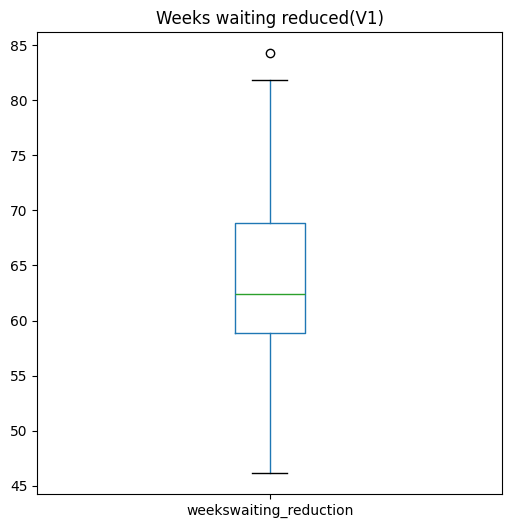

In [1759]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
extract_date = pd.to_datetime("2024-04-30")
overbooked_df["calculated_weekswaiting"] = (pd.to_datetime(overbooked_df["original_overbooked_appt_date"]) - extract_date).dt.days / 7
overbooked_df["true_weekswaiting"] = overbooked_df["original_overbooked_weekswaiting"] + overbooked_df["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
overbooked_df["weekswaiting_reduction"] = overbooked_df["true_weekswaiting"] - overbooked_df["time_gap_weeks"]
print("Mean of weeks waiting reduced:", overbooked_df["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced:", overbooked_df["weekswaiting_reduction"].median())

# Plot boxplot
overbooked_df.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(V1)")
plt.show()

### V2: overbook any (other risk levels) into very high risk - using multiple queues

In [1760]:
# Create queues for the "other risk level" appointments
queue10_V2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10[["appointment_id", "appt_date"]].values.tolist()])
queue15_V2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15[["appointment_id", "appt_date"]].values.tolist()])
queue20_V2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20[["appointment_id", "appt_date"]].values.tolist()])
queue30_V2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30[["appointment_id", "appt_date"]].values.tolist()])
queue75_V2 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time_V2 = len(queue10_V2)*10 + len(queue15_V2)*15 + len(queue20_V2)*20 + len(queue30_V2)*30 + len(queue75_V2)*75
print("Sum of starting queue time (V2):", queue_time_V2)

Sum of starting queue time (V2): 32475


In [1761]:
# Function to overbook the very high risk appointments - with multiple queues ==> returns same results as appts in queue > # of very high risk appts
def overbook_appointments_multi_queue(very_high_group, queues):
    overbooked_appointments = []
    for index, very_high_appt in very_high_group.iterrows():
        very_high_date = pd.to_datetime(very_high_appt["appt_date"])
        overbooked = False
        for queue in queues:
            temp_queue = deque()  # Temporary queue to hold appointments that are not suitable for the current very_high_appt
            while queue and not overbooked:
                # Pop the earliest appointment from the queue
                earliest_appointment_id, earliest_date = queue.popleft()
                # Check if the very_high_date is earlier than the earliest_date
                if very_high_date < earliest_date:
                    # Overbook the very high risk slot with the remaining appointment
                    overbooked_appointments.append((very_high_appt["appointment_id"], earliest_appointment_id))
                    overbooked = True
                    break
                else:
                    # If the date is not suitable, move the appointment to the temporary queue
                    temp_queue.append((earliest_appointment_id, earliest_date))
            # Merge the temporary queue back into the original queue
            queue.extendleft(reversed(temp_queue))
            if overbooked:
                break
        if not overbooked:
            # No more appointments to overbook
            overbooked_appointments.append((very_high_appt["appointment_id"], None))
    return overbooked_appointments

# Define separate queues by including the "shorter" queues
queues_10 = [queue10_V2]
queues_15 = [queue15_V2, queue10_V2]
queues_20 = [queue20_V2, queue15_V2, queue10_V2]
queues_30 = [queue30_V2, queue20_V2, queue15_V2, queue10_V2]
queues_75 = [queue75_V2, queue30_V2, queue20_V2, queue15_V2, queue10_V2]

# Overbook each very high risk appointment duration group
overbooked_10_V2 = overbook_appointments_multi_queue(surgeon_new_very_high_10, queues_10)
overbooked_15_V2 = overbook_appointments_multi_queue(surgeon_new_very_high_15, queues_15)
overbooked_20_V2 = overbook_appointments_multi_queue(surgeon_new_very_high_20, queues_20)
overbooked_30_V2 = overbook_appointments_multi_queue(surgeon_new_very_high_30, queues_30)
overbooked_75_V2 = overbook_appointments_multi_queue(surgeon_new_very_high_75, queues_75)

# Combine all overbooked results
all_overbooked_appointments_V2 = overbooked_10_V2 + overbooked_15_V2 + overbooked_20_V2 + overbooked_30_V2+ overbooked_75_V2

# Convert to DataFrame
overbooked_df_V2 = pd.DataFrame(all_overbooked_appointments_V2, columns=["very_high_appt_id", "overbooked_appt_id"])
overbooked_df_V2

,very_high_appt_id,overbooked_appt_id
0,19853208,19971567.0
1,20111728,NaN
2,17671208,17671294.0
3,17901062,17667391.0
4,18011196,20112378.0
...,...,...
233,19938829,20141614.0
234,19971221,19881525.0
235,19972250,20056268.0
236,20055757,20055807.0


In [1762]:
# Calculate time gap of the overbooked appointments (original vs new/overbooked)

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df_V2 = pd.merge(overbooked_df_V2, 
                            data[["appointment_id", "appt_date", "did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                                          "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df_V2 = pd.merge(overbooked_df_V2,
                            data[["appointment_id", "appt_date", "did_not_attend_risk", "weekswaiting","appt_duration"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk",
                                                                                                                          "weekswaiting": "original_overbooked_weekswaiting",}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])

# Calculate the time gap between the original and overbooked appointments
overbooked_df_V2["time_gap_days"] = (pd.to_datetime(overbooked_df_V2["original_overbooked_appt_date"]) - pd.to_datetime(overbooked_df_V2["very_high_appt_date"])).dt.days

# Convert time_gap_days into weeks
overbooked_df_V2["time_gap_weeks"] = overbooked_df_V2["time_gap_days"] / 7

overbooked_df_V2

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,time_gap_days,time_gap_weeks
0,19853208,19971567.0,2025-01-29,0.619074,2025-01-30,0.344912,7.0,10.0,1.0,0.142857
1,20111728,NaN,2025-04-02,0.656163,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,17671294.0,2024-05-20,0.710675,2024-05-23,0.318434,59.0,15.0,3.0,0.428571
3,17901062,17667391.0,2024-05-09,0.455411,2024-05-20,0.261759,60.0,15.0,11.0,1.571429
4,18011196,20112378.0,2024-05-23,0.775510,2025-03-07,0.275752,59.0,15.0,288.0,41.142857
...,...,...,...,...,...,...,...,...,...,...
233,19938829,20141614.0,2025-04-15,0.473121,2025-05-06,0.179040,11.0,30.0,21.0,3.000000
234,19971221,19881525.0,2025-04-15,0.489043,2025-04-24,0.291788,9.0,30.0,9.0,1.285714
235,19972250,20056268.0,2025-05-29,0.461040,2025-07-24,0.244307,8.0,30.0,56.0,8.000000
236,20055757,20055807.0,2025-07-03,0.793514,2025-07-17,0.408785,6.0,30.0,14.0,2.000000


Avg. time gap (V1): 34.59915611814346
Median time gap (V1): 17.0


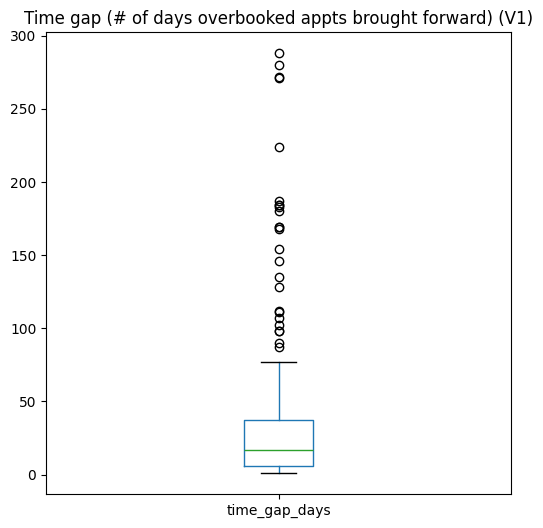

In [1763]:
# Calculate the average time gap
print("Avg. time gap (V1):", overbooked_df_V2["time_gap_days"].mean())
print("Median time gap (V1):", overbooked_df_V2["time_gap_days"].median())


# Plot boxplot
overbooked_df_V2.boxplot(column="time_gap_days", figsize=(6, 6), grid=False)
plt.title("Time gap (# of days overbooked appts brought forward) (V1)")
plt.show()

In [1764]:
# Count the remaining appointments in each queue
remaining_10_V2 = len(queue10_V2) * 10
remaining_15_V2 = len(queue15_V2) * 15
remaining_20_V2 = len(queue20_V2) * 20
remaining_30_V2 = len(queue30_V2) * 30
remaining_75_V2 = len(queue75_V2) * 75

# Sum the remaining appointments
remainder_queue_time_V2 = remaining_10_V2 + remaining_15_V2 + remaining_20_V2 + remaining_30_V2 + remaining_75_V2
remainder_queue_time_V2

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (V2):", overbooked_df_V2["appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (V2):", queue_time_V2 - remainder_queue_time_V2)

Sum of overbooked duration (V2): 3870.0
Sum of queue utilised (V2): 3870


Mean joint probability (V2): 0.15468837227421017
Median joint probability (V2): 0.14394197680627172


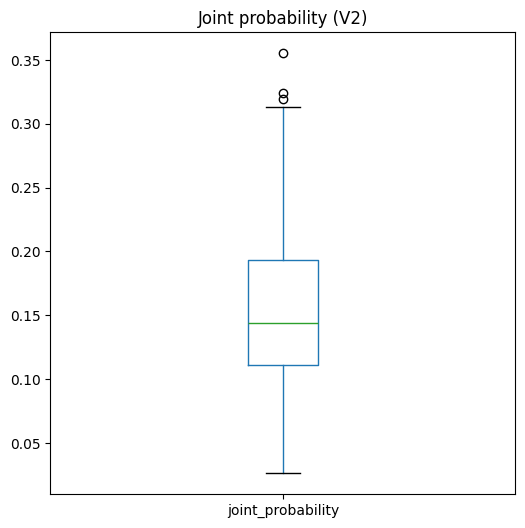

In [1765]:
# Calculate probability of clinic overtime
overbooked_df_V2["joint_probability"] = overbooked_df_V2["very_high_dna_risk"] * overbooked_df_V2["original_overbooked_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (V2):", overbooked_df_V2["joint_probability"].mean())
print("Median joint probability (V2):", overbooked_df_V2["joint_probability"].median())

# Plot boxplot
overbooked_df_V2.boxplot(column="joint_probability", figsize=(6, 6), grid=False)
plt.title("Joint probability (V2)")
plt.show()


Mean clinic overtime (per appointment scenario) (V2): 5.056564466031308
Median clinic overtime (per appointment scenario) (V2): 4.519610507729897
Spread of clinic overtime (Q3-Q1): 2.738828736169388


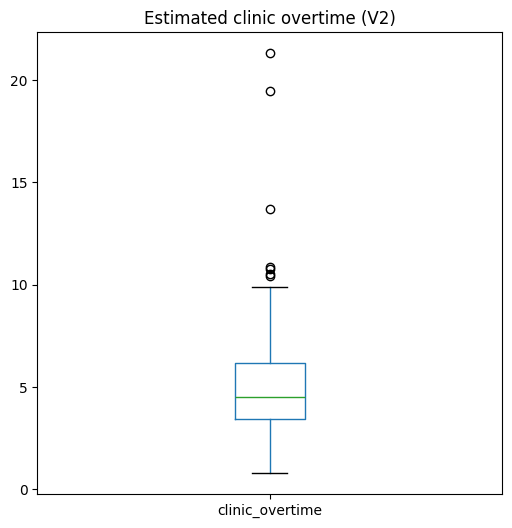

In [1766]:
# Calculate estimated clinic overtime
overbooked_df_V2["clinic_overtime"] = overbooked_df_V2["joint_probability"] * (overbooked_df_V2["appt_duration"]*2)

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (V2):", overbooked_df_V2["clinic_overtime"].mean())
print("Median clinic overtime (per appointment scenario) (V2):", overbooked_df_V2["clinic_overtime"].median())

# Quantiles - what you want is the spread (Q3-Q1) to be as small as possible
print("Spread of clinic overtime (Q3-Q1):", overbooked_df_V2["clinic_overtime"].quantile(0.75) - overbooked_df_V2["clinic_overtime"].quantile(0.25))

# Plot boxplot
overbooked_df_V2.boxplot(column="clinic_overtime", figsize=(6, 6), grid=False)
plt.title("Estimated clinic overtime (V2)")
plt.show()

Mean of weeks waiting reduced: 63.34538878842678
Median of weeks waiting reduced: 62.42857142857143


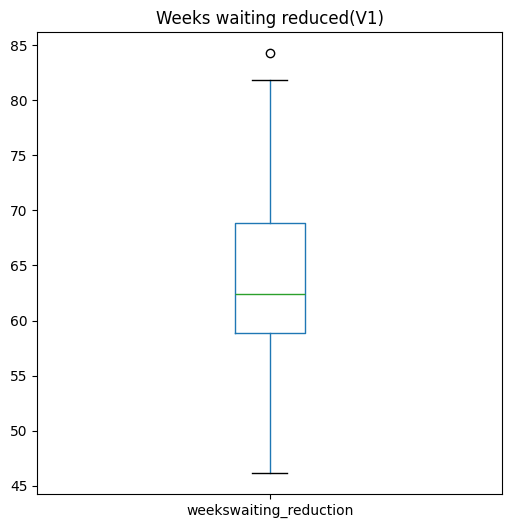

In [1767]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
overbooked_df_V2["calculated_weekswaiting"] = (pd.to_datetime(overbooked_df_V2["original_overbooked_appt_date"]) - extract_date).dt.days / 7
overbooked_df_V2["true_weekswaiting"] = overbooked_df_V2["original_overbooked_weekswaiting"] + overbooked_df_V2["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
overbooked_df_V2["weekswaiting_reduction"] = overbooked_df_V2["true_weekswaiting"] - overbooked_df_V2["time_gap_weeks"]
print("Mean of weeks waiting reduced:", overbooked_df_V2["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced:", overbooked_df_V2["weekswaiting_reduction"].median())

# Plot boxplot
overbooked_df_V2.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(V1)")
plt.show()

### V3: overbook low & moderate risks into very high risk based on weeks waiting

In [1768]:
# Sort the individual appointment durations by weekswaiting (low & moderate risk)
weekswaiting_desc_10_V3 = surgeon_new_10[(surgeon_new_10["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_10["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_15_V3 = surgeon_new_15[(surgeon_new_15["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_15["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_20_V3 = surgeon_new_20[(surgeon_new_20["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_20["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_30_V3 = surgeon_new_30[(surgeon_new_30["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_30["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)
weekswaiting_desc_75_V3 = surgeon_new_75[(surgeon_new_75["did_not_attend_risk_group_trans"] == 1) | (surgeon_new_75["did_not_attend_risk_group_trans"] == 2)].sort_values(by="weekswaiting", ascending=False)

# Create queues for the "other risk level" appointments
queue10_V3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10_V3[["appointment_id", "appt_date"]].values.tolist()])
queue15_V3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15_V3[["appointment_id", "appt_date"]].values.tolist()])
queue20_V3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20_V3[["appointment_id", "appt_date"]].values.tolist()])
queue30_V3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30_V3[["appointment_id", "appt_date"]].values.tolist()])
queue75_V3 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75_V3[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time_V3 = len(queue10_V3)*10 + len(queue15_V3)*15 + len(queue20_V3)*20 + len(queue30_V3)*30 + len(queue75_V3)*75
print("Sum of starting queue time (V3):", queue_time_V3)




Sum of starting queue time (V3): 8880


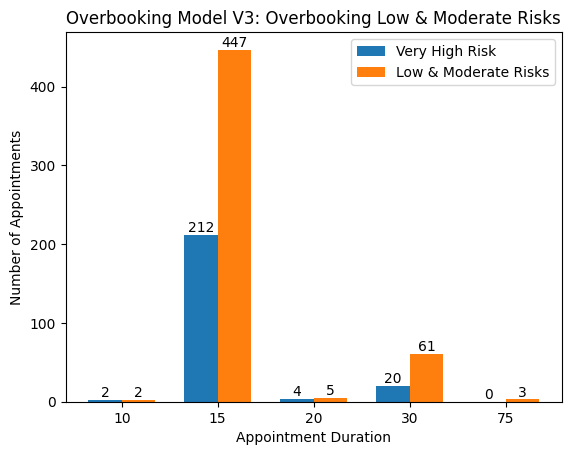

In [1769]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10_V3),
    len(queue15_V3),
    len(queue20_V3),
    len(queue30_V3),
    len(queue75_V3),
]

# Define the durations
durations = [10, 15, 20, 30, 75]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Low & Moderate Risks")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model V3: Overbooking Low & Moderate Risks")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [1770]:
# Overbook each very high risk appointment duration group by using the same overbooking function as V1
overbooked_10_V3 = overbook_appointments(surgeon_new_very_high_10, queue10_V3)
overbooked_15_V3 = overbook_appointments(surgeon_new_very_high_15, queue15_V3)
overbooked_20_V3 = overbook_appointments(surgeon_new_very_high_20, queue20_V3)
overbooked_30_V3 = overbook_appointments(surgeon_new_very_high_30, queue30_V3)
overbooked_75_V3 = overbook_appointments(surgeon_new_very_high_75, queue75_V3)

# Combine all overbooked results
all_overbooked_appointments_V3 = overbooked_10_V3 + overbooked_15_V3 + overbooked_20_V3 + overbooked_30_V3 + overbooked_75_V3

# Convert to DataFrame
overbooked_df_V3 = pd.DataFrame(all_overbooked_appointments_V3, columns=["very_high_appt_id", "overbooked_appt_id"])
overbooked_df_V3



,very_high_appt_id,overbooked_appt_id
0,19853208,NaN
1,20111728,NaN
2,17671208,20026346.0
3,17901062,20026219.0
4,18011196,20025984.0
...,...,...
233,19938829,NaN
234,19971221,NaN
235,19972250,NaN
236,20055757,NaN


In [1771]:
# Calculate time gap of the overbooked appointments (original vs new/overbooked)

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df_V3 = pd.merge(overbooked_df_V3, 
                            data[["appointment_id", "appt_date", "did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                         "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df_V3 = pd.merge(overbooked_df_V3,
                            data[["appointment_id", "appt_date", "did_not_attend_risk", "weekswaiting", "appt_duration"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk",
                                                                                                                          "weekswaiting": "original_overbooked_weekswaiting"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])

# Calculate the time gap between the original and overbooked appointments
overbooked_df_V3["time_gap_days"] = (pd.to_datetime(overbooked_df_V3["original_overbooked_appt_date"]) - pd.to_datetime(overbooked_df_V3["very_high_appt_date"])).dt.days

# Convert time_gap_days into weeks
overbooked_df_V3["time_gap_weeks"] = overbooked_df_V3["time_gap_days"] / 7

overbooked_df_V3

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_dna_risk,original_overbooked_weekswaiting,appt_duration,time_gap_days,time_gap_weeks
0,19853208,NaN,2025-01-29,0.619074,NaN,NaN,NaN,NaN,NaN,NaN
1,20111728,NaN,2025-04-02,0.656163,NaN,NaN,NaN,NaN,NaN,NaN
2,17671208,20026346.0,2024-05-20,0.710675,2024-08-27,0.061545,54.0,15.0,99.0,14.142857
3,17901062,20026219.0,2024-05-09,0.455411,2025-01-15,0.175142,53.0,15.0,251.0,35.857143
4,18011196,20025984.0,2024-05-23,0.775510,2024-08-20,0.081328,48.0,15.0,89.0,12.714286
...,...,...,...,...,...,...,...,...,...,...
233,19938829,NaN,2025-04-15,0.473121,NaN,NaN,NaN,NaN,NaN,NaN
234,19971221,NaN,2025-04-15,0.489043,NaN,NaN,NaN,NaN,NaN,NaN
235,19972250,NaN,2025-05-29,0.461040,NaN,NaN,NaN,NaN,NaN,NaN
236,20055757,NaN,2025-07-03,0.793514,NaN,NaN,NaN,NaN,NaN,NaN


Avg. time gap (V3): 27.114155251141554
Median time gap (V3): 12.0


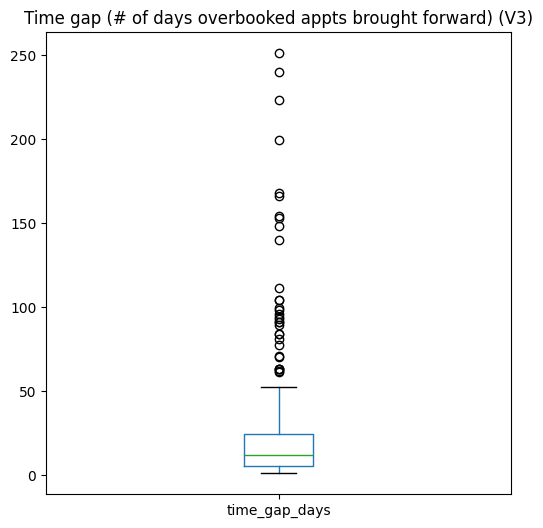

In [1772]:
# Calculate the average & median time gap
print("Avg. time gap (V3):", overbooked_df_V3["time_gap_days"].mean())
print("Median time gap (V3):", overbooked_df_V3["time_gap_days"].median())


# Plot boxplot
overbooked_df_V3.boxplot(column="time_gap_days", figsize=(6, 6), grid=False)
plt.title("Time gap (# of days overbooked appts brought forward) (V3)")
plt.show()

In [1773]:
# Count the remaining appointments in each queue
remaining_10_V3 = len(queue10_V3) * 10
remaining_15_V3 = len(queue15_V3) * 15
remaining_20_V3 = len(queue20_V3) * 20
remaining_30_V3 = len(queue30_V3) * 30
remaining_75_V3 = len(queue75_V3) * 75

# Sum the remaining appointments
remainder_queue_time_V3 = remaining_10_V3 + remaining_15_V3 + remaining_20_V3 + remaining_30_V3 + remaining_75_V3
remainder_queue_time_V3

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (V3):", overbooked_df_V3["appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (V3):", queue_time_V3 - remainder_queue_time_V3)

Sum of overbooked duration (V3): 3525.0
Sum of queue utilised (V3): 3525


Mean joint probability (V3): 0.08603446505987453
Median joint probability (V3): 0.08299015394023007


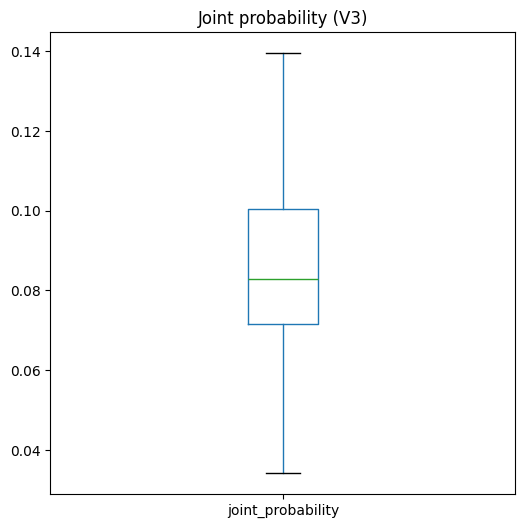

In [1774]:
# Calculate probability of clinic overtime
overbooked_df_V3["joint_probability"] = overbooked_df_V3["very_high_dna_risk"] * overbooked_df_V3["original_overbooked_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (V3):", overbooked_df_V3["joint_probability"].mean())
print("Median joint probability (V3):", overbooked_df_V3["joint_probability"].median())

# Plot boxplot
overbooked_df_V3.boxplot(column="joint_probability", figsize=(6, 6), grid=False)
plt.title("Joint probability (V3)")
plt.show()

Mean clinic overtime (per appointment scenario) (V3): 2.7943643837621726
Median clinic overtime (per appointment scenario) (V3): 2.5232199135557267
Spread of clinic overtime (Q3-Q1): 0.9339049039871217


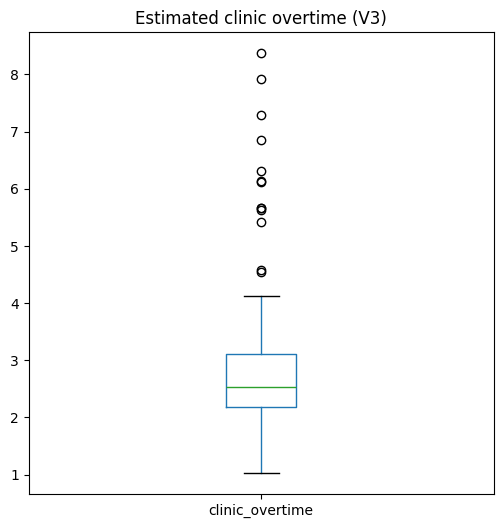

In [1775]:
# Calculate estimated clinic overtime
overbooked_df_V3["clinic_overtime"] = overbooked_df_V3["joint_probability"] * (overbooked_df_V3["appt_duration"]*2)

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (V3):", overbooked_df_V3["clinic_overtime"].mean())
print("Median clinic overtime (per appointment scenario) (V3):", overbooked_df_V3["clinic_overtime"].median())

# Quantiles - what you want is the spread (Q3-Q1) to be as small as possible
print("Spread of clinic overtime (Q3-Q1):", overbooked_df_V3["clinic_overtime"].quantile(0.75) - overbooked_df_V3["clinic_overtime"].quantile(0.25))

# Plot boxplot
overbooked_df_V3.boxplot(column="clinic_overtime", figsize=(6, 6), grid=False)
plt.title("Estimated clinic overtime (V3)")
plt.show()

Mean of weeks waiting reduced: 52.89041095890411
Median of weeks waiting reduced: 50.28571428571428


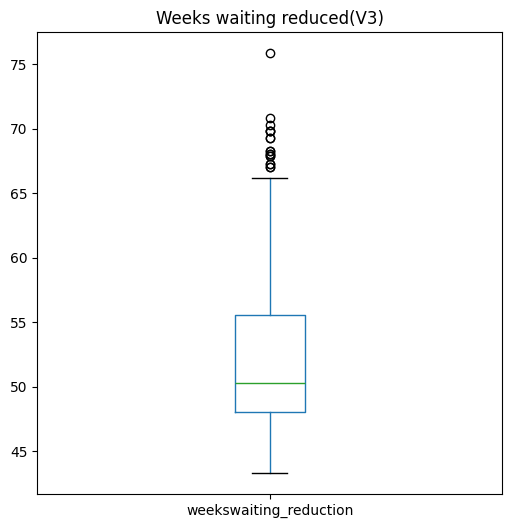

In [1776]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
overbooked_df_V3["calculated_weekswaiting"] = (pd.to_datetime(overbooked_df_V3["original_overbooked_appt_date"]) - extract_date).dt.days / 7
overbooked_df_V3["true_weekswaiting"] = overbooked_df_V3["original_overbooked_weekswaiting"] + overbooked_df_V3["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
overbooked_df_V3["weekswaiting_reduction"] = overbooked_df_V3["true_weekswaiting"] - overbooked_df_V3["time_gap_weeks"]
print("Mean of weeks waiting reduced:", overbooked_df_V3["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced:", overbooked_df_V3["weekswaiting_reduction"].median())

# Plot boxplot
overbooked_df_V3.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(V3)")
plt.show()

### V4: under-overbook (eg. overbook a 20min in a 30min slot) to avoid clinic overtime; low + moderate + high

In [1777]:
# Using the same queues and function as V1
# Recreate the queues for the "other risk level" appointments
queue10_V4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_10[["appointment_id", "appt_date"]].values.tolist()])
queue15_V4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_15[["appointment_id", "appt_date"]].values.tolist()])
queue20_V4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_20[["appointment_id", "appt_date"]].values.tolist()])
queue30_V4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_30[["appointment_id", "appt_date"]].values.tolist()])
queue75_V4 = deque([(id, pd.to_datetime(date)) for id, date in weekswaiting_desc_75[["appointment_id", "appt_date"]].values.tolist()])

# Sum the duration of queued appointments
queue_time_V4 = len(queue10_V4)*10 + len(queue15_V4)*15 + len(queue20_V4)*20 + len(queue30_V4)*30 + len(queue75_V4)*75
print("Sum of starting queue time (V4):", queue_time_V4)

Sum of starting queue time (V4): 32475


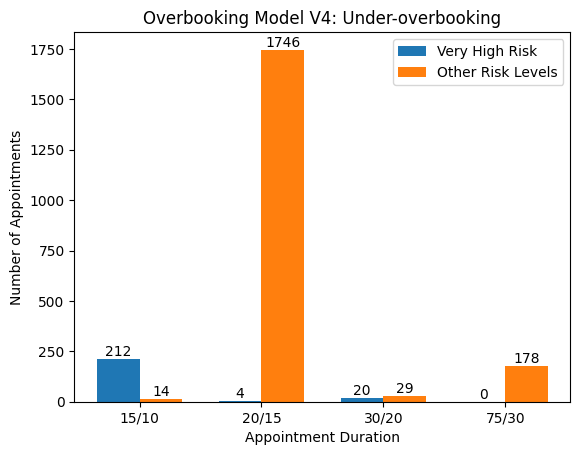

In [1778]:
# Plot number of the very high risk appointments against the queues to compare
# Count the number of appointments for each duration
very_high_counts = [
    # len(surgeon_new_very_high_10),
    len(surgeon_new_very_high_15),
    len(surgeon_new_very_high_20),
    len(surgeon_new_very_high_30),
    len(surgeon_new_very_high_75),
]

other_risk_counts = [
    len(queue10_V4),
    len(queue15_V4),
    len(queue20_V4),
    len(queue30_V4),
    # len(queue75_V4),
]

# Define the durations
durations = ["15/10", "20/15", "30/20", "75/30"]

# Plot the data
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Bar positions
ind = range(len(durations))

# Create the bar plots
bars1 = ax.bar(ind, very_high_counts, width, label="Very High Risk")
bars2 = ax.bar([i + width for i in ind], other_risk_counts, width, label="Other Risk Levels")

# Add labels, title, and legend
ax.set_xlabel("Appointment Duration")
ax.set_ylabel("Number of Appointments")
ax.set_title("Overbooking Model V4: Under-overbooking")
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(durations)
ax.legend()

# Add data values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

# Display the plot
plt.show()

In [1779]:
# Overbook each very high risk appointment duration group
# Not possible for 10-minute appiontments as no shorter duration appointments available
overbooked_15_V4 = overbook_appointments(surgeon_new_very_high_15, queue10_V4)
overbooked_20_V4 = overbook_appointments(surgeon_new_very_high_20, queue15_V4)
overbooked_30_V4 = overbook_appointments(surgeon_new_very_high_30, queue20_V4)
overbooked_75_V4 = overbook_appointments(surgeon_new_very_high_75, queue30_V4)

# Combine all overbooked results
all_overbooked_appointments_V4 = overbooked_15_V4 + overbooked_20_V4 + overbooked_30_V4 + overbooked_75_V4

# Convert to DataFrame
overbooked_df_V4 = pd.DataFrame(all_overbooked_appointments_V4, columns=["very_high_appt_id", "overbooked_appt_id"])

# Append appointment dates to the overbooked_df
# 1. For the very high risk appointments
overbooked_df_V4 = pd.merge(overbooked_df_V4, 
                            data[["appointment_id", "appt_date", "appt_duration" ,"did_not_attend_risk"]].rename(columns={"appt_date": "very_high_appt_date",
                                                                                                                          "appt_duration": "very_high_appt_duration",
                                                                                                                          "did_not_attend_risk": "very_high_dna_risk"}), 
                            left_on="very_high_appt_id", 
                            right_on="appointment_id", 
                            how="left").drop(columns=["appointment_id"])
# 2. For the overbooked appointments (incl. appt duration & DNA risk score)
overbooked_df_V4 = pd.merge(overbooked_df_V4,
                            data[["appointment_id", "appt_date", "appt_duration", "did_not_attend_risk", "weekswaiting"]].rename(columns={"appt_date": "original_overbooked_appt_date",
                                                                                                                          "appt_duration": "original_overbooked_appt_duration",
                                                                                                                          "did_not_attend_risk": "original_overbooked_dna_risk",
                                                                                                                          "weekswaiting": "original_overbooked_weekswaiting"}),
                            left_on="overbooked_appt_id",
                            right_on="appointment_id",
                            how="left").drop(columns=["appointment_id"])


# Calculate the time gap between the original and overbooked appointments
overbooked_df_V4["time_gap_days"] = (pd.to_datetime(overbooked_df_V4["original_overbooked_appt_date"]) - pd.to_datetime(overbooked_df_V4["very_high_appt_date"])).dt.days

# Convert time_gap_days into weeks
overbooked_df_V4["time_gap_weeks"] = overbooked_df_V4["time_gap_days"] / 7

overbooked_df_V4

,very_high_appt_id,overbooked_appt_id,very_high_appt_date,very_high_appt_duration,very_high_dna_risk,original_overbooked_appt_date,original_overbooked_appt_duration,original_overbooked_dna_risk,original_overbooked_weekswaiting,time_gap_days,time_gap_weeks
0,17671208,18616180.0,2024-05-20,15.0,0.710675,2024-06-20,10.0,0.384087,42.0,31.0,4.428571
1,17901062,18296387.0,2024-05-09,15.0,0.455411,2024-07-10,10.0,0.246540,38.0,62.0,8.857143
2,18011196,18748587.0,2024-05-23,15.0,0.775510,2024-08-12,10.0,0.209423,29.0,81.0,11.571429
3,18012765,18867602.0,2024-05-02,15.0,0.574464,2024-09-11,10.0,0.241837,27.0,132.0,18.857143
4,18017248,19268866.0,2024-05-29,15.0,0.582589,2024-09-30,10.0,0.243421,21.0,124.0,17.714286
...,...,...,...,...,...,...,...,...,...,...,...
231,19938829,19664457.0,2025-04-15,30.0,0.473121,2025-07-07,20.0,0.257243,15.0,83.0,11.857143
232,19971221,19664473.0,2025-04-15,30.0,0.489043,2025-07-14,20.0,0.277879,15.0,90.0,12.857143
233,19972250,19517889.0,2025-05-29,30.0,0.461040,2025-06-09,20.0,0.413918,15.0,11.0,1.571429
234,20055757,19826747.0,2025-07-03,30.0,0.793514,2025-08-18,20.0,0.312378,12.0,46.0,6.571429


Avg. time gap (V4): 103.94736842105263
Median time gap (V4): 99.5


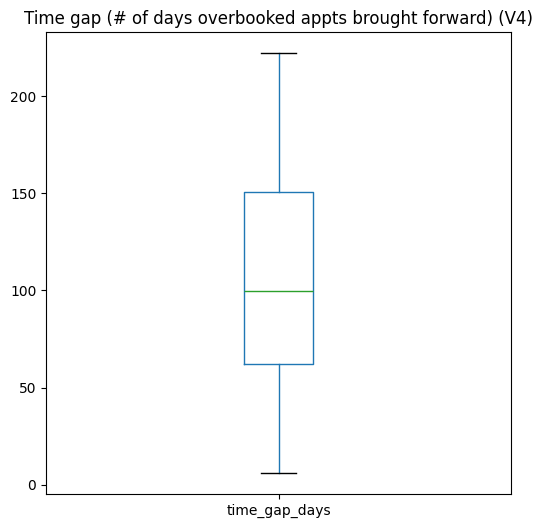

In [1780]:
# Calculate the average time gap
print("Avg. time gap (V4):", overbooked_df_V4["time_gap_days"].mean())
print("Median time gap (V4):", overbooked_df_V4["time_gap_days"].median())


# Plot boxplot
overbooked_df_V4.boxplot(column="time_gap_days", figsize=(6, 6), grid=False)
plt.title("Time gap (# of days overbooked appts brought forward) (V4)")
plt.show()

In [1781]:
# Count the remaining appointments in each queue
remaining_10_V4 = len(queue10_V4) * 10
remaining_15_V4 = len(queue15_V4) * 15
remaining_20_V4 = len(queue20_V4) * 20
remaining_30_V4 = len(queue30_V4) * 30
remaining_75_V4 = len(queue75_V4) * 75

# Sum the remaining appointments
remainder_queue_time_V4 = remaining_10_V4 + remaining_15_V4 + remaining_20_V4 + remaining_30_V4 + remaining_75_V4
remainder_queue_time_V4

# Sum the duration of the overbooked appointments
print("Sum of overbooked duration (V4):", overbooked_df_V4["original_overbooked_appt_duration"].sum())

# Calculate the total duration of the overbooked appointments utilised
print("Sum of queue utilised (V4):", queue_time_V4 - remainder_queue_time_V4)

Sum of overbooked duration (V4): 600.0
Sum of queue utilised (V4): 600


Mean joint probability (V4): 0.1593634688293736
Median joint probability (V4): 0.15180191357333714


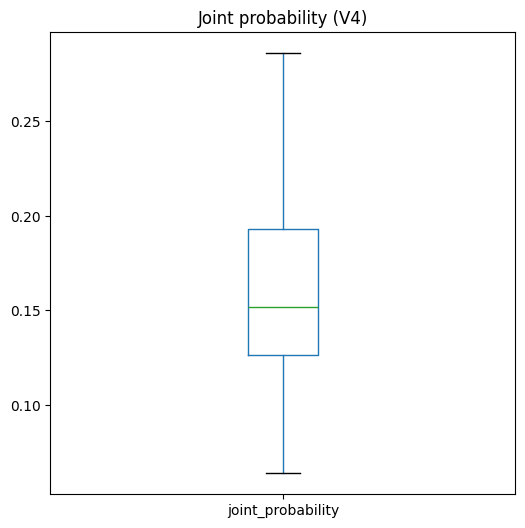

In [1782]:
# Calculate probability of clinic overtime
overbooked_df_V4["joint_probability"] = overbooked_df_V4["very_high_dna_risk"] * overbooked_df_V4["original_overbooked_dna_risk"]

# Calculate the mean joint probability
print("Mean joint probability (V4):", overbooked_df_V4["joint_probability"].mean())
print("Median joint probability (V4):", overbooked_df_V4["joint_probability"].median())

# Plot boxplot
overbooked_df_V4.boxplot(column="joint_probability", figsize=(6, 6), grid=False)
plt.title("Joint probability (V4)")
plt.show()

Mean clinic overtime (per appointment scenario) (V4): 6.379100138477346
Median clinic overtime (per appointment scenario) (V4): 5.7898405392379955
Spread of clinic overtime (Q3-Q1): 4.90837128714784


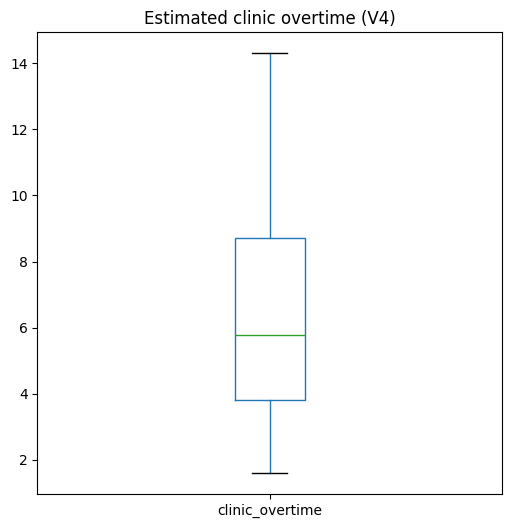

In [1783]:
# Calculate estimated clinic overtime
overbooked_df_V4["clinic_overtime"] = overbooked_df_V4["joint_probability"] * (overbooked_df_V4["very_high_appt_duration"] + overbooked_df_V4["original_overbooked_appt_duration"])

# Calculate the mean clinic overtime
print("Mean clinic overtime (per appointment scenario) (V4):", overbooked_df_V4["clinic_overtime"].mean())
print("Median clinic overtime (per appointment scenario) (V4):", overbooked_df_V4["clinic_overtime"].median())

# Quantiles - what you want is the spread (Q3-Q1) to be as small as possible
print("Spread of clinic overtime (Q3-Q1):", overbooked_df_V4["clinic_overtime"].quantile(0.75) - overbooked_df_V4["clinic_overtime"].quantile(0.25))

# Plot boxplot
overbooked_df_V4.boxplot(column="clinic_overtime", figsize=(6, 6), grid=False)
plt.title("Estimated clinic overtime (V4)")
plt.show()

Mean of weeks waiting reduced: 49.27067669172932
Median of weeks waiting reduced: 51.5


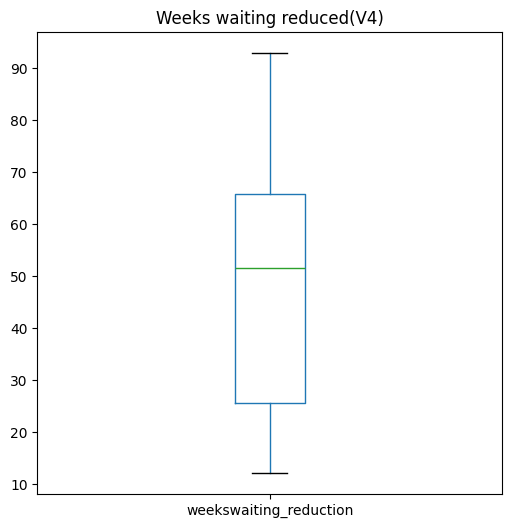

In [1784]:
# Calculate reduction in weeks waiting

# Calculate true # of weeks waiting based on date of data extracted (30 April 2024)
overbooked_df_V4["calculated_weekswaiting"] = (pd.to_datetime(overbooked_df_V4["original_overbooked_appt_date"]) - extract_date).dt.days / 7
overbooked_df_V4["true_weekswaiting"] = overbooked_df_V4["original_overbooked_weekswaiting"] + overbooked_df_V4["calculated_weekswaiting"]

# Calculate the reduction in weeks waiting
overbooked_df_V4["weekswaiting_reduction"] = overbooked_df_V4["true_weekswaiting"] - overbooked_df_V4["time_gap_weeks"]
print("Mean of weeks waiting reduced:", overbooked_df_V4["weekswaiting_reduction"].mean())
print("Median of weeks waiting reduced:", overbooked_df_V4["weekswaiting_reduction"].median())

# Plot boxplot
overbooked_df_V4.boxplot(column="weekswaiting_reduction", figsize=(6, 6), grid=False)
plt.title("Weeks waiting reduced(V4)")
plt.show()

### V5: Calculate max capacity (per weekday) for new surgeon appointments and overbook by creating extra time slots 

In [1657]:
# Import historic ENT appointments
historic = pd.read_csv("../historic_appts_first_pred_trans_ENT.csv")
historic.head()

,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
0,12088942,42,27.45,NaN,0,0,0,4,0,1,...,First prediction,1.0,3,2024-02-14,2,3,10,6,0,3
1,12207851,42,27.45,NaN,1,0,1,4,0,0,...,First prediction,1.0,3,2024-03-12,3,3,10,6,0,4
2,12791383,27,21.70,NaN,0,0,0,3,0,0,...,First prediction,1.0,3,2024-01-31,1,3,10,6,0,2
3,12940266,42,27.45,NaN,1,0,0,2,0,0,...,First prediction,1.0,3,2024-04-03,4,3,10,6,0,1
4,13428133,83,21.70,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2024-04-05,4,3,10,6,0,3


In [1645]:
# Count total duration per day of historic appointments
historic_duration = historic.groupby("appt_date")["appt_duration"].sum().reset_index()
historic_duration

,appt_date,appt_duration
0,2023-11-24,420.0
1,2023-11-25,670.0
2,2023-11-26,600.0
3,2023-11-27,550.0
4,2023-11-28,560.0
...,...,...
127,2024-04-22,640.0
128,2024-04-23,1210.0
129,2024-04-24,705.0
130,2024-05-17,15.0


In [1646]:
# Convert to weekdays

# Convert appt_date to datetime
historic_duration["appt_date"] = pd.to_datetime(historic_duration["appt_date"])

# Extract the day of the week
historic_duration["weekday"] = historic_duration["appt_date"].dt.day_name()

# Sum the duration of appointments per day of the week
historic_duration.groupby("weekday")["appt_duration"].sum()

weekday
Friday       13070.0
Monday       15995.0
Saturday      9190.0
Sunday        8000.0
Thursday     16065.0
Tuesday      20685.0
Wednesday    14280.0
Name: appt_duration, dtype: float64

In [1647]:
# Filter for historic surgeons & new appointments only ("Adult ENT New", "Adult ENT Thyroid New", "Adult ENT Emergency Clinic New", "Adult ENT Emergency Nose Fracture New")
historic_surgeon_new = historic[historic["reason_display_trans"].isin([8, 18, 4, 5])]
historic_surgeon_new


,appointment_id,age_deid,bmi_deid,ethnicity,ethnic_category_black,ethnic_category_unknown,gender_male,imd19_quintile,main_spoken_language_other,current_smoker,...,prediction_type,case_control,use_case,appt_date,appt_month_trans,hospital_service_display_trans,service_mapping_trans,reason_display_trans,appointment_type_trans,did_not_attend_risk_group_trans
161,16704068,83,39.45,NaN,0,0,0,2,0,1,...,First prediction,1.0,3,2023-11-28,11.0,3,10,8,0,3
162,16705803,67,21.70,NaN,0,0,0,2,0,0,...,First prediction,1.0,3,2023-11-28,11.0,3,10,8,0,3
243,16949904,57,40.00,NaN,1,0,0,1,0,0,...,First prediction,1.0,3,2023-12-05,12.0,3,10,8,0,2
294,17132130,22,27.45,NaN,0,0,1,3,0,0,...,First prediction,1.0,3,2024-02-05,2.0,3,10,8,0,4
302,17169300,27,27.45,NaN,0,0,1,1,0,0,...,First prediction,1.0,3,2023-11-28,11.0,3,10,8,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5770,20187445,27,21.70,NaN,0,0,0,1,0,1,...,First prediction,1.0,3,2024-04-18,4.0,3,10,5,0,3
5779,20209428,2,27.45,NaN,0,0,1,3,0,0,...,First prediction,1.0,3,2024-04-23,4.0,3,10,4,0,1
5782,20213745,22,27.45,NaN,0,1,0,1,1,0,...,First prediction,1.0,3,2024-04-23,4.0,3,10,4,0,2
5783,20219731,27,39.45,NaN,0,0,0,3,0,1,...,First prediction,1.0,3,2024-04-22,4.0,3,10,4,0,2


In [1648]:
# Total duration per day of historic surgeon & new appointments only
historic_surgeon_new_duration = historic_surgeon_new.groupby("appt_date")["appt_duration"].sum().reset_index()

# Convert appt_date to datetime
historic_surgeon_new_duration["appt_date"] = pd.to_datetime(historic_surgeon_new_duration["appt_date"])

historic_surgeon_new_duration


,appt_date,appt_duration
0,2023-11-24,240.0
1,2023-11-25,640.0
2,2023-11-26,450.0
3,2023-11-27,230.0
4,2023-11-28,225.0
...,...,...
116,2024-04-18,415.0
117,2024-04-19,60.0
118,2024-04-22,210.0
119,2024-04-23,455.0


In [1649]:
# Calculate proportion of surgeon_new out of all historic appointments

# Merge the dfs on appt_date
merged_historic_durations = pd.merge(historic_duration, historic_surgeon_new_duration, on="appt_date", suffixes=("_total", "_surgeon_new"))

# Calculate the proportion
merged_historic_durations["proportion"] = merged_historic_durations["appt_duration_surgeon_new"] / merged_historic_durations["appt_duration_total"]
merged_historic_durations

# Find the mean proportion (i.e. the average proportion of surgeon_new out of all historic appointments)
merged_historic_durations.groupby("weekday")["proportion"].mean()


weekday
Friday       0.408793
Monday       0.408010
Saturday     0.785410
Sunday       0.856306
Thursday     0.461325
Tuesday      0.408847
Wednesday    0.440559
Name: proportion, dtype: float64

In [1650]:
# Calculate avg. max minutes per week day for surgeon_new
max_weekday_surgeon_new = merged_historic_durations.groupby("weekday")["appt_duration_total"].sum() * merged_historic_durations.groupby("weekday")["proportion"].mean()
max_weekday_surgeon_new

weekday
Friday       5336.792294
Monday       6526.112648
Saturday     5654.954577
Sunday       6191.095448
Thursday     7411.192749
Tuesday      8456.998974
Wednesday    6284.569442
dtype: float64

In [1651]:
# Find out total duration of surgeon_new appointments for the future ENT appointments


### Compare the 4 models

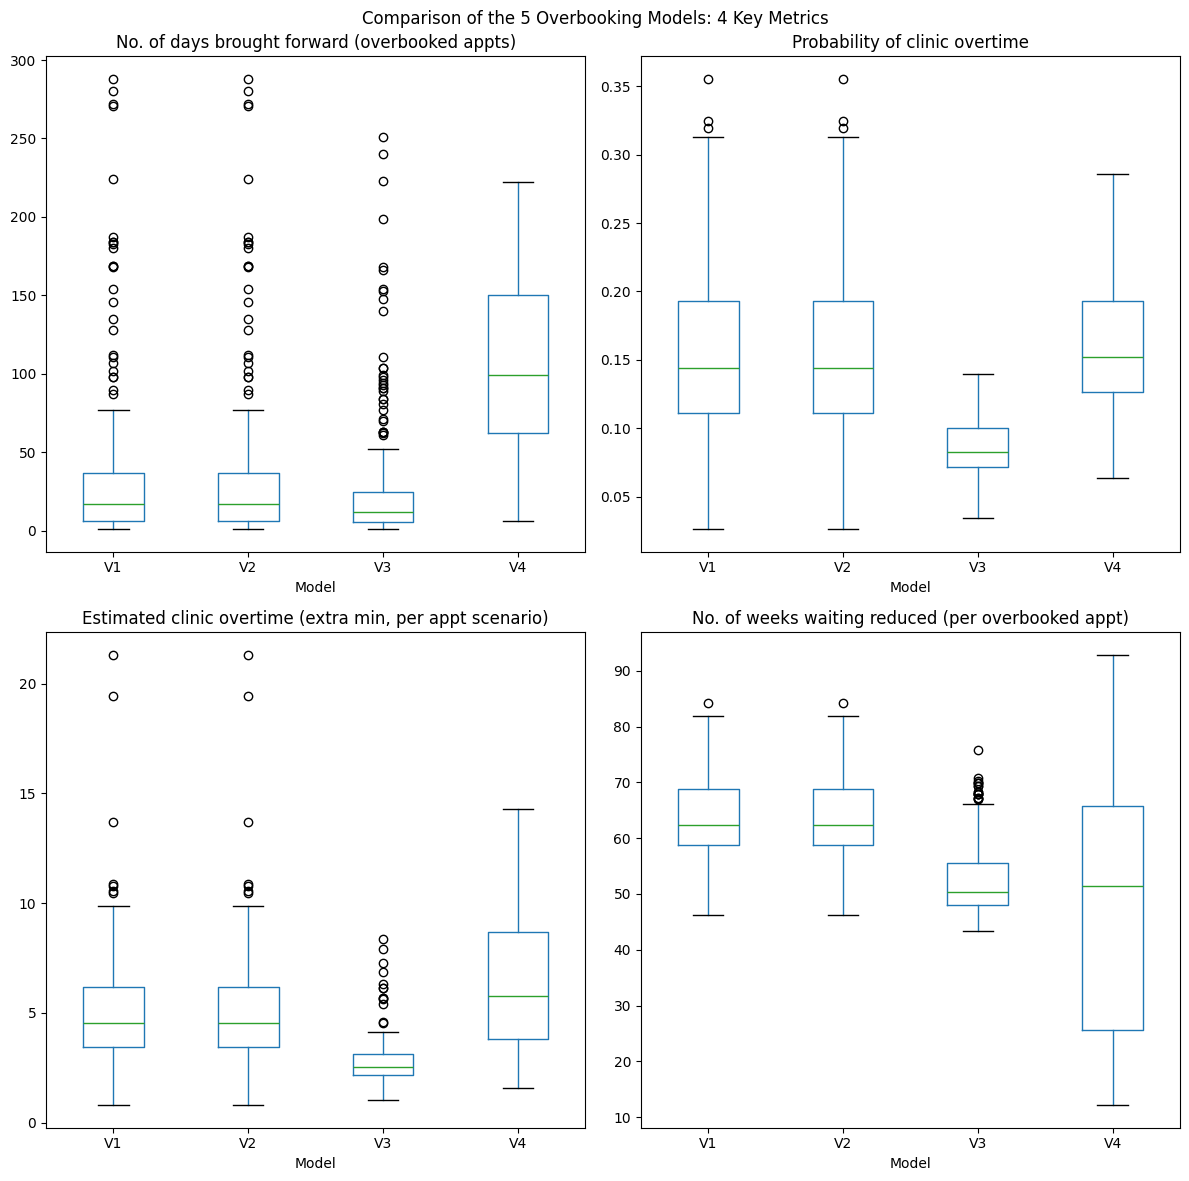

In [1785]:
# Combine the data into one dataframe with an additional column to differentiate them
overbooked_df['Model'] = 'V1'
overbooked_df_V2['Model'] = 'V2'
overbooked_df_V3['Model'] = 'V3'
overbooked_df_V4['Model'] = 'V4'

columns_to_keep = ["time_gap_days", "joint_probability", "clinic_overtime", "weekswaiting_reduction", "Model"]
combined_df = pd.concat([overbooked_df[columns_to_keep], overbooked_df_V2[columns_to_keep], overbooked_df_V3[columns_to_keep], overbooked_df_V4[columns_to_keep]])

# Create the subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Plot the combined boxplots on one of the subplots (e.g., top-right subplot which is axs[0, 1])
combined_df.boxplot(column="time_gap_days", by="Model", ax=axs[0, 0], grid=False)
axs[0, 0].set_title("No. of days brought forward (overbooked appts)")

# Joint probability boxplot
combined_df.boxplot(column="joint_probability", by="Model", ax=axs[0, 1], grid=False)
axs[0, 1].set_title("Probability of clinic overtime")

# Clinic overtime boxplot
combined_df.boxplot(column="clinic_overtime", by="Model", ax=axs[1, 0], grid=False)
axs[1, 0].set_title("Estimated clinic overtime (extra min, per appt scenario)")

# Weeks waiting reduction boxplot
combined_df.boxplot(column="weekswaiting_reduction", by="Model", ax=axs[1, 1], grid=False)
axs[1, 1].set_title("No. of weeks waiting reduced (per overbooked appt)")

# Adjust layout for better spacing
plt.suptitle('Comparison of the 5 Overbooking Models: 4 Key Metrics')
plt.tight_layout()

# Show plot
plt.show()

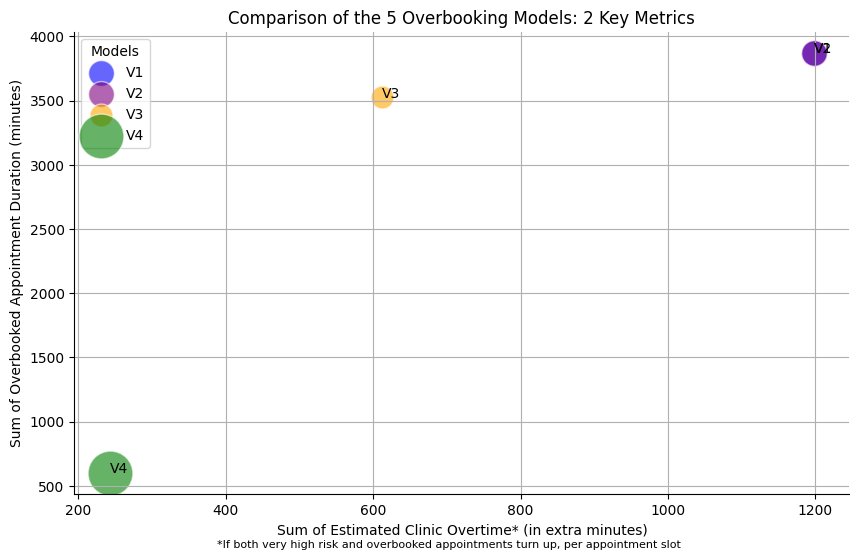

In [1786]:
# Create a dictionary with comparison metrics for the 4 models
compare_model = {
    'Version': ['V1', 'V2', 'V3', 'V4'],
    'Sum of Estimated Clinic Overtime (extra minutes)': [
        overbooked_df["clinic_overtime"].sum(),
        overbooked_df_V2["clinic_overtime"].sum(), 
        overbooked_df_V3["clinic_overtime"].sum(), 
        overbooked_df_V4["clinic_overtime"].sum()
    ],
    'Sum of Overbooked Appointment Duration (minutes)': [
        overbooked_df["appt_duration"].sum(), 
        overbooked_df_V2["appt_duration"].sum(),
        overbooked_df_V3["appt_duration"].sum(),
        overbooked_df_V4["original_overbooked_appt_duration"].sum()
    ],
    'Avg. time gap (days)': [
        overbooked_df["time_gap_days"].mean(),
        overbooked_df_V2["time_gap_days"].mean(),
        overbooked_df_V3["time_gap_days"].mean(),
        overbooked_df_V4["time_gap_days"].mean()
    ]
}

# Convert it into a DataFrame
df = pd.DataFrame(compare_model)

# Plot the scatter plot with time gap as size of marker
plt.figure(figsize=(10, 6))

# Scatter plot for each version
colors = ['blue', 'purple', 'orange', 'green']
for i in range(len(df)):
    plt.scatter(df['Sum of Estimated Clinic Overtime (extra minutes)'][i], 
                df['Sum of Overbooked Appointment Duration (minutes)'][i], 
                s=df['Avg. time gap (days)'][i] * 10, # Scale marker size
                color=colors[i],
                alpha=0.6,
                edgecolors="w",
                label=df['Version'][i])

# Adding labels to each point
for i, txt in enumerate(df['Version']):
    plt.annotate(txt, (df['Sum of Estimated Clinic Overtime (extra minutes)'][i], df['Sum of Overbooked Appointment Duration (minutes)'][i]), fontsize=10)

plt.xlabel('Sum of Estimated Clinic Overtime* (in extra minutes)')
plt.ylabel('Sum of Overbooked Appointment Duration (minutes)')
plt.title('Comparison of the 5 Overbooking Models: 2 Key Metrics')
plt.legend(title='Models')
plt.grid(True)


# Remove the top and right spines (outside borders)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding the footnote
plt.figtext(0.5, 0.02, '*If both very high risk and overbooked appointments turn up, per appointment slot', ha='center', fontsize=8)

plt.show()

### Result: end output

In [1654]:
# Overbooked df

In [1655]:
# # of overbooked appts per day

In [1656]:
# Mean clinic overtime per day (per week?)
overbooked_df_V3["clinic_overtime"].groupby(overbooked_df_V3["very_high_appt_date"]).mean()

very_high_appt_date
2024-05-02    2.465309
2024-05-08    2.608918
2024-05-09    2.392853
2024-05-10    2.561298
2024-05-14    4.585008
                ...   
2025-07-31    2.874506
2025-08-11         NaN
2025-08-19         NaN
2025-09-15    2.352281
2025-10-09         NaN
Name: clinic_overtime, Length: 156, dtype: float64